# Predicting Insurance Costs with Linear Regression

The purpose of this notebook is to offer as a an example answer to the Guided Project for Linear Regression in Python course. Since the choice of model predictors is up to the student, results can differ. Use this solution as a guide to how to structure your own answer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load in and preview the insurance dataset
insurance = pd.read_csv('insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploratory Data Analysis (EDA)

In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


There are 7 columns in this dataset, with 1338 rows of data. There are no null values, but there are three `object` data types that will need to be addresed if they are to be used in the linear regression model: `sex`, `smoker`, and `region`.

In [4]:
# Viewing summary statistics for numeric variables
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


- `charges` has very different **mean** and **median** values, indicating possible skew
- all other data quality quick checks appear in reasonably normal ranges

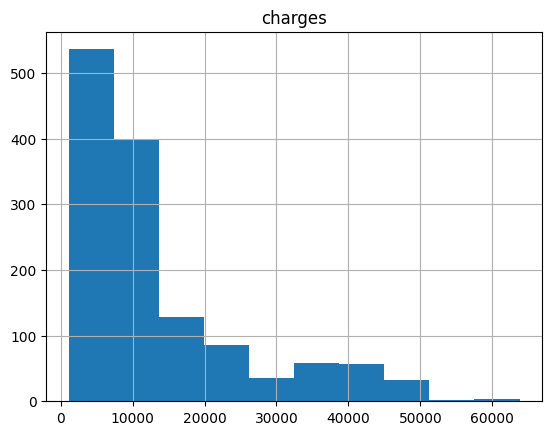

In [5]:
# visualizing the charges column to look for skew
insurance.hist('charges')
plt.show()

The `charges` column is,in fact, highly skewed to the right. Extremely costly insurance charges are less common than extremely small ones. This makes it unlikely that the errors in the model will truly be centered at zero. It might be worth it to log-transform the outcome.

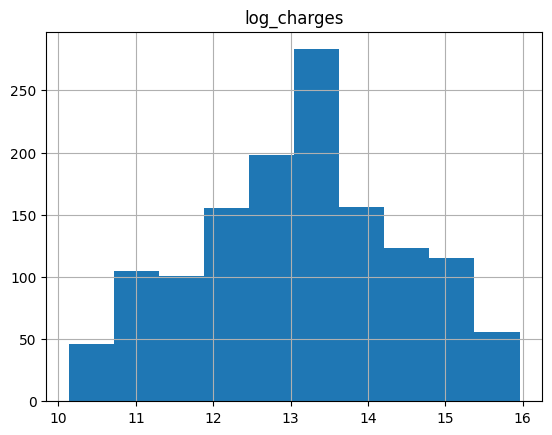

In [6]:
#transforming charges using a base-2 log (note that natural log can be used as well)
insurance["log_charges"] = np.log2(insurance["charges"])

# visualizing transformed charges shape
insurance.hist("log_charges")
plt.show()

In [7]:
# Checking the correlation between the continuous columns in the insurance data
correlations = insurance.corr()
correlations

,age,bmi,children,charges,log_charges
age,1.000000,0.109272,0.042469,0.299008,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.892964
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000


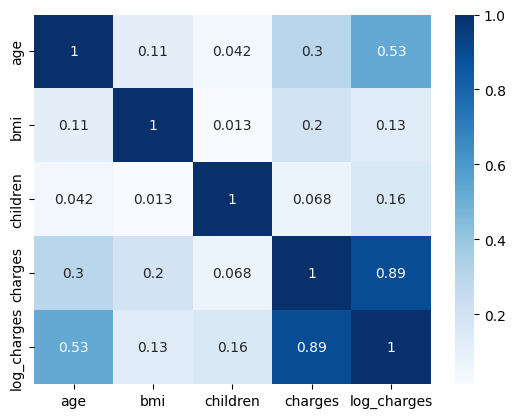

In [8]:
# visualizing correlations with a heatmap
sns.heatmap(correlations, cmap='Blues', annot=True)
plt.show()

- `age` has 30% correlation with `charges` and a 53% correlation with `log_charges`
- `bmi` has 20% correlation with `charges` and a 13% correlation with `log_charges`
- `children` has 6.7% correlation with `charges` and a 16% correlation with `log_charges`

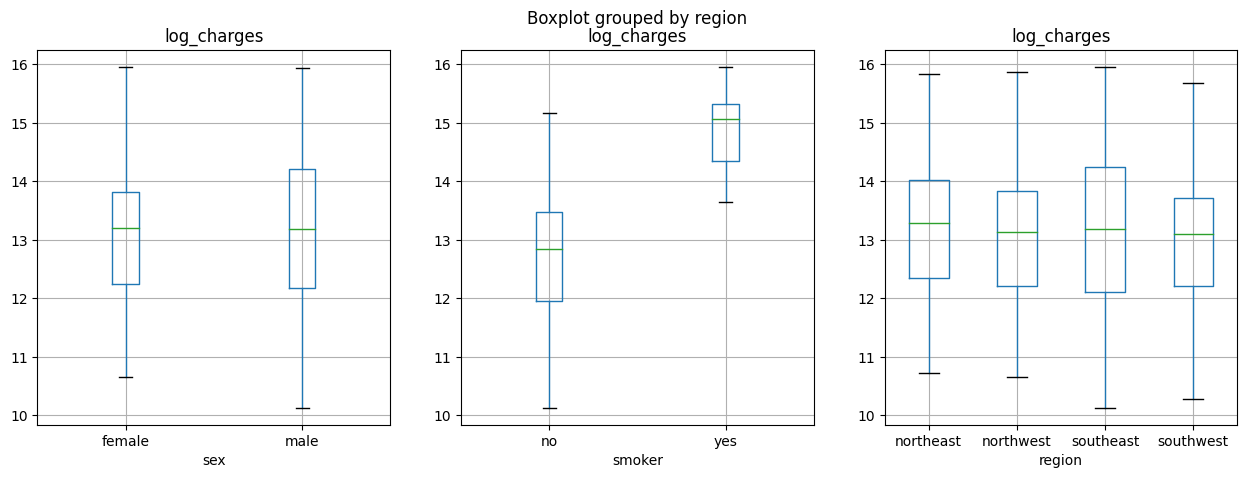

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

insurance.boxplot(column=["log_charges"], by="sex", ax=axs[0])
insurance.boxplot(column=["log_charges"], by="smoker", ax=axs[1])
insurance.boxplot(column=["log_charges"], by="region", ax=axs[2])

plt.show()

- Males seem to have a wider distribution of charges compared to women.
- Smokers have much higher costs than non-smokers.
- There don't seem to be many appreciable differences between regions.

### Determining the features:
Based on the univariate relationships shown above, `age`, `bmi`, and `smoker`are positively associated with higher charges. We'll include these predictors in our final model.

## Dividing the Data

In [10]:
# converting the smoker variable into numeric data
insurance["is_smoker"] = (insurance["smoker"] == "yes")

# setting independent and dependent variables
X = insurance[["age", "bmi", "is_smoker"]]
y = insurance["log_charges"]

# Splitting the data up into a training and test set with 75% for training set, 25% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=42)

## Building the Model

In [11]:
# Training and checking model performance on training set
insurance_model = LinearRegression()
insurance_model.fit(X_train, y_train)

LinearRegression()

In [12]:
# Get predicted values by model
y_pred = insurance_model.predict(X_train)

In [13]:
# Training MSE on the log scale for the insurance charges
train_mse = mean_squared_error(y_train, y_pred)
train_mse

0.44791919632992105

In [14]:
# Training MSE on the original scale for the insurance charges
train_mse_orig_scale = np.exp2(mean_squared_error(y_train, y_pred))
train_mse_orig_scale

1.3640714326864816

In [15]:
# Coefficient of determination
train_r2 = r2_score(y_train, y_pred)
train_r2

0.7433336007728248

The training MSE for the model is 0.448 and is 1.36 on the original scale. The `r2` indicates that the model can explain 74% of the variation in the log-insurance charges. These preliminary results are promising, but we must remember that these are optimistic values.

## Residual Diagnostics

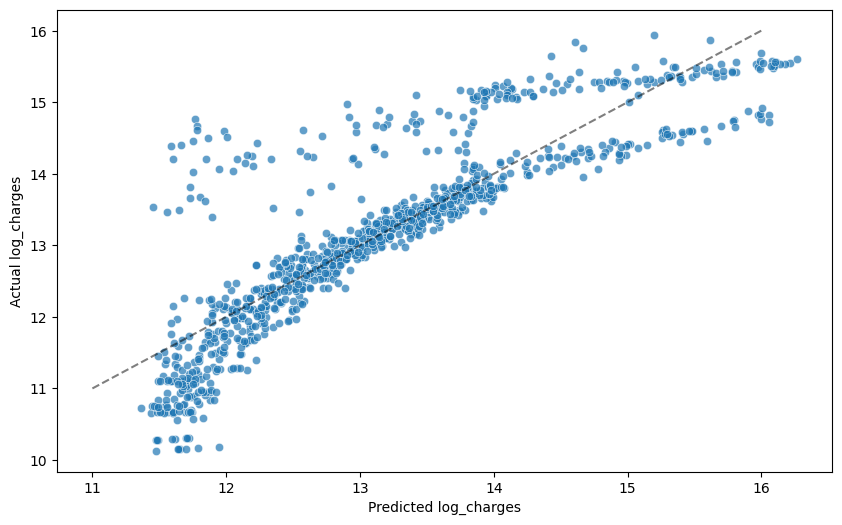

In [16]:
# Create a DataFrame with predictions, actual values, and residuals for easier plotting
plot_df = pd.DataFrame({
    'predictions': y_pred,
    'actual': y_train,
    'is_smoker': X_train['is_smoker'],
    'age': X_train['age'],
    'bmi': X_train['bmi'],
    'residuals': y_train - y_pred,
})

# Quick visual check of actual values versus predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predictions', y='actual', 
                data=plot_df, alpha=0.7)
# Create a reference line
plt.plot([11, 16], [11, 16], 'k--', alpha=0.5)


plt.xlabel('Predicted log_charges')
plt.ylabel('Actual log_charges')

plt.show()

Our reference line compared to our scatter plot show that our model is not doing a very good job of predicting linearly. We need to investigate further.

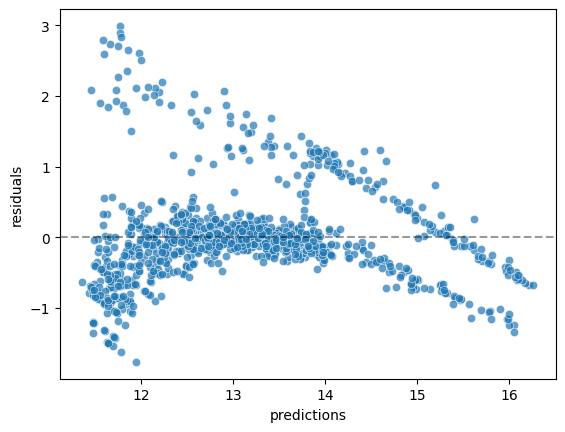

In [17]:
# Quick visual check of residuals
sns.scatterplot(x='predictions', y='residuals', 
                data=plot_df, alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.4)
plt.show()

The residuals suggest some violations to the assumptions of linear regression. As predicted values get larger, the residuals trend downward. We expect an even band, centered around zero. This does not necessarily make the model predictions unusable, but it puts into question the linear regression assumptions.

## Interpreting the Model

In [18]:
cdf = pd.DataFrame(insurance_model.coef_, X.columns, columns=['Coef'])
print(cdf)

               Coef
age        0.050862
bmi        0.015637
is_smoker  2.232148


In [19]:
insurance_model.intercept_

10.199942936238687

**Translating this into a "concept"**  
Note that the formula below is just to exemplify what the linear regression equation would look like:

$$charges = 0.05 \times age + 0.016 \times bmi + 2.232 \times is\_smoker + 10.2$$

- A year increase in `age` in the subject is associated with a 0.05 increase in the log charges, holding smoking status and bmi constant.
- A unit increase in the subject `bmi` is associated with a 0.016 increase in the log charges, holding smoking status and age constant.
- A `smoker` is associated with a 2.23 increase in the log charges, holding age and bmi constant.

Note: we are not concerned about if these changes are statistically significant, so we don't know if these associations are truly non-zero. Our primary goal is prediction.

## Final Model Evaluation

In [20]:
# Getting MSE on test model
test_pred = insurance_model.predict(X_test)

mean_squared_error(y_test, test_pred)

0.4529281560931769

In [21]:
# Putting the outcome (in log-terms) back into the original scale
np.exp2(mean_squared_error(y_test, test_pred))

1.368815646563475

## Drawing Conclusions

The test MSE was about 0.453, while the training MSE was about 0.443. In this case, the two errors match up pretty well, so we can conclude that the model is not overfit. The residuals suggest that the model is predicting much lower costs for subjects who were actually charged much higher. Therefore the model struggles with these higher costs. As a whole, the model predictions are too conservative.

We might improve the model by including more complex terms in the regression, such as interactions or quadratic terms.

## Next Steps

### Segmenting by smoker status

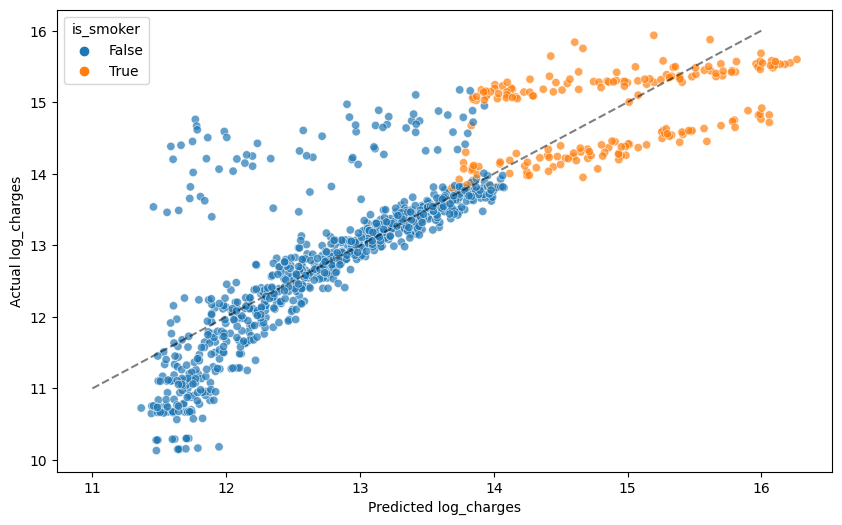

In [22]:
# Quick visual check of actual values versus predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predictions', y='actual', 
                data=plot_df, alpha=0.7, hue='is_smoker')
# Create a reference line
plt.plot([11, 16], [11, 16], 'k--', alpha=0.5)


plt.xlabel('Predicted log_charges')
plt.ylabel('Actual log_charges')

plt.show()

When we add a `hue` argument to the `actual` versus `predicted` scatterplot we can see that `is_smoker` has a stark segmentation within the data. Because of this, one continuation of this project is to segment the data into smokers versus non-smokers and train two separate models to account for potential fundamental differences in how medical costs are calculated for the two groups.

In [23]:
# creating a smokers-only dataframe
smokers_df = insurance[insurance["is_smoker"] == True]

In [24]:
X_smokers = smokers_df[["age", "bmi"]]
y_smokers = smokers_df["log_charges"]

# 75% for training set, 25% for test set
X_smokers_train, X_smokers_test, y_smokers_train, y_smokers_test = train_test_split(X_smokers, y_smokers, test_size=0.25, 
                                                    random_state=42)

In [25]:
smoker_model = LinearRegression()
smoker_model.fit(X_smokers_train, y_smokers_train)
smoker_model.coef_

array([0.01282851, 0.07098738])

In [26]:
y_smokers_pred = smoker_model.predict(X_smokers_train)

In [27]:
train_smokers_mse = mean_squared_error(y_smokers_train, y_smokers_pred)
train_smokers_mse

0.07046354357369704

In [28]:
train_smokers_r2 = r2_score(y_smokers_train, y_smokers_pred)
train_smokers_r2

0.7661650418251628

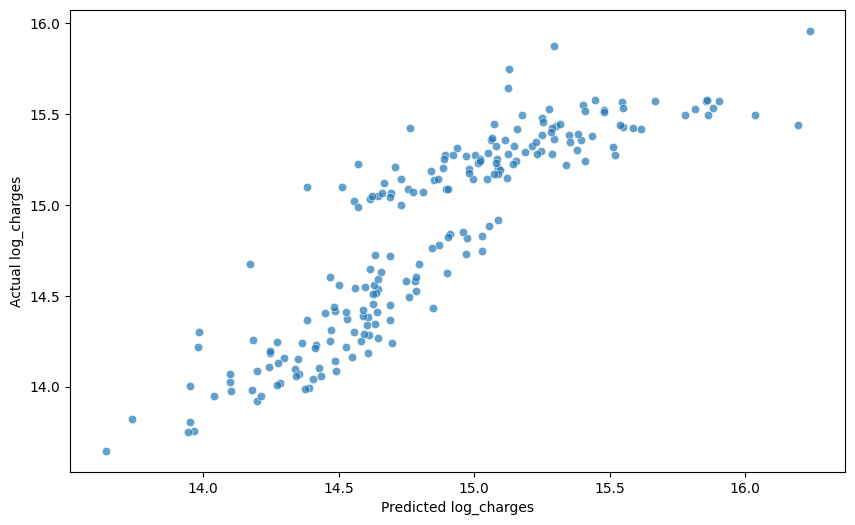

In [29]:
# Create a DataFrame with predictions and actual values for easier plotting
plot_smokers_df = pd.DataFrame({
    'predictions': y_smokers_pred,
    'actual': y_smokers_train,
    'age': X_smokers_train['age'],
    'bmi': X_smokers_train['bmi'],
    'residuals': y_smokers_train - y_smokers_pred,
})

# Create scatter plot with hue for smoker status
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predictions', y='actual', 
                data=plot_smokers_df, alpha=0.7)

plt.xlabel('Predicted log_charges')
plt.ylabel('Actual log_charges')

plt.show()

The relationship between predicted and actual values still shows some non-linearity but overall the visual more-strongly supports the argument that linear regression is applicable to this dataset.

<AxesSubplot:xlabel='predictions', ylabel='residuals'>

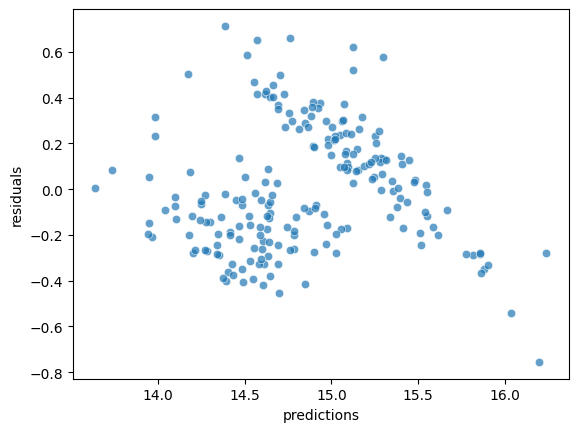

In [30]:
# visualizing residuals
sns.scatterplot(x='predictions', y='residuals', 
                data=plot_smokers_df, alpha=0.7)

There is still some clusting/non-randomness when viewing residuals, but overall the graph is a slight improvement.

In [31]:
test_smokers_pred = smoker_model.predict(X_smokers_test)

# Smoker MSE:
print(f"Smoker MSE: {mean_squared_error(y_smokers_test, test_smokers_pred)}")
print(f"Original scale smoker MSE: {np.exp2(mean_squared_error(y_smokers_test, test_smokers_pred))}")

# Original model MSE:
print(f"ALL MSE: {mean_squared_error(y_test, test_pred)}")
print(f"Original scale ALL MSE: {np.exp2(mean_squared_error(y_test, test_pred))}")

Smoker MSE: 0.09416078156173782
Original scale smoker MSE: 1.0674442930460954
ALL MSE: 0.4529281560931769
Original scale ALL MSE: 1.368815646563475


The MSE is much better than the original model! 0.09 compared to 0.45.